# Нейронная сеть уровня шума аэродинамического профиля

Исходные данные:

1. Частота [Гц].
2. Угол атаки [град].
3. Длина хорды аэродинамического профиля [м].
4. Скорость набегающего потока [м/с].
5. Толщина аэродинамического профиля [м].

Результирующие данные:

6. Масштабированный уровень звукового давления [Дб].

# Импорт библиотек

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('D:/Programming/Python')

In [3]:
from tools import show_correlation, export2, rounding
from decorators import timeit
from ml_tools import pairplot, training_plot, predictions_plot

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, Input, Dense
from tensorflow.keras import Sequential
from tensorflow.keras import activations
from tensorflow import optimizers

print(f'tensorflow.__version__: {tf.__version__}')

tensorflow.__version__: 2.15.0


# Определение констант

In [5]:
NORMALIZATORS = tuple()
MODELS = tuple()

# Импорт датасета

In [6]:
os.listdir()

['airfoil_self_noise.dat',
 'app.py',
 'model.pkl',
 'home.html',
 'Airfoil Self-Noise - UCI Machine Learning Repository.html',
 'airfoil_noise_by_sklearn.ipynb',
 'airfoil_noise_by_tf.ipynb',
 'exports',
 'checkpoints',
 'model_airfoil_noise.keras',
 'airfoil_noise_by_tf.html']

In [7]:
df = pd.read_csv("airfoil_self_noise.dat", sep="\t", header=None)
df

,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [18]:
df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1503 non-null   int64  
 1   1       1503 non-null   float64
 2   2       1503 non-null   float64
 3   3       1503 non-null   float64
 4   4       1503 non-null   float64
 5   5       1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


# Обработка датасета

In [ ]:
df.columns = ["Frequency [Hz]", "Attack angle [deg]", "Chord length [m]", "Free-stream velocity [m/s]", "Thickness [m]", "Pressure level [db]"]

In [ ]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


Проверка однотипности данных и локальных пустот

In [ ]:
df.isna().sum()

Frequency [Hz]                0
Attack angle [deg]            0
Chord length [m]              0
Free-stream velocity [m/s]    0
Thickness [m]                 0
Pressure level [db]           0
dtype: int64

In [ ]:
if not all(df.isna().sum()): df.dropna(inplace=True)

In [ ]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


# Анализ данных

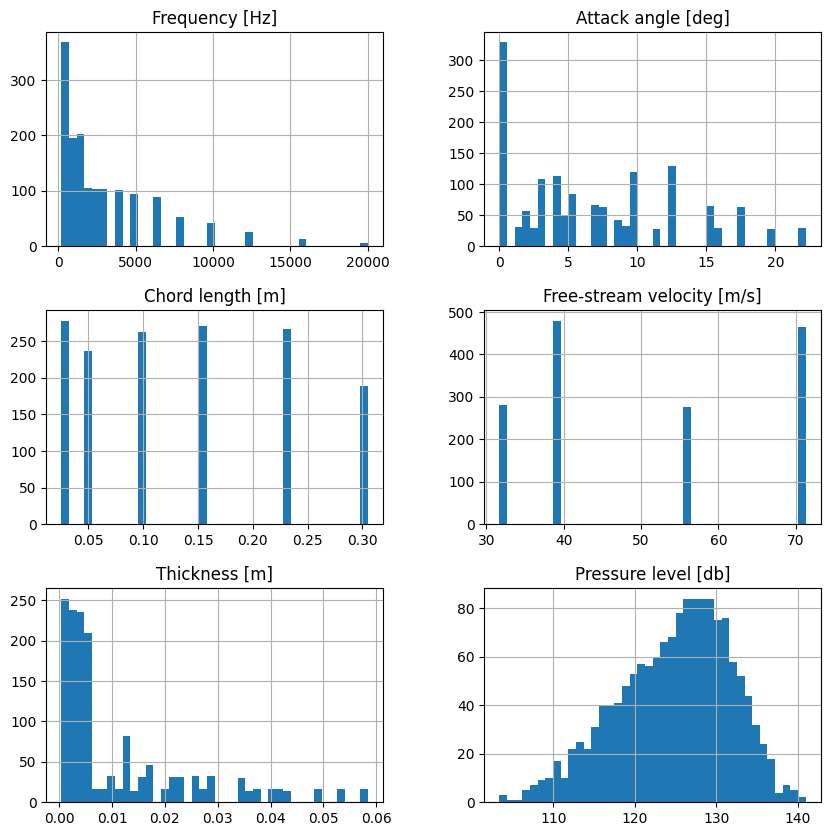

In [ ]:
df.hist(figsize=(10, 10), bins=40);

In [ ]:
df.columns

Index(['Frequency [Hz]', 'Attack angle [deg]', 'Chord length [m]',
       'Free-stream velocity [m/s]', 'Thickness [m]', 'Pressure level [db]'],
      dtype='object')

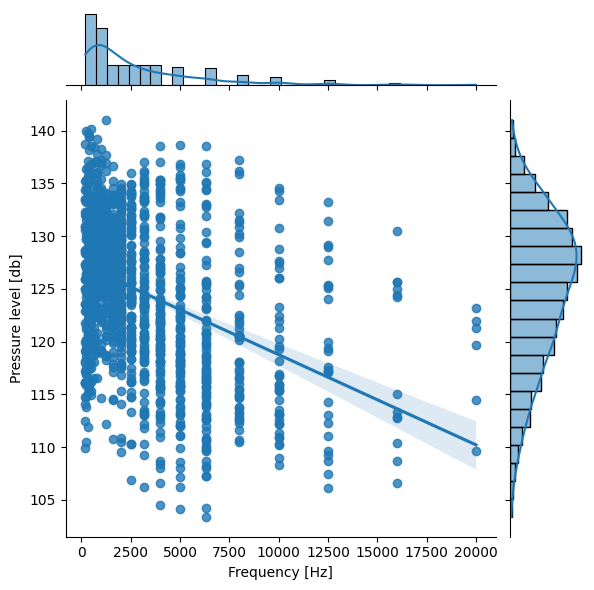

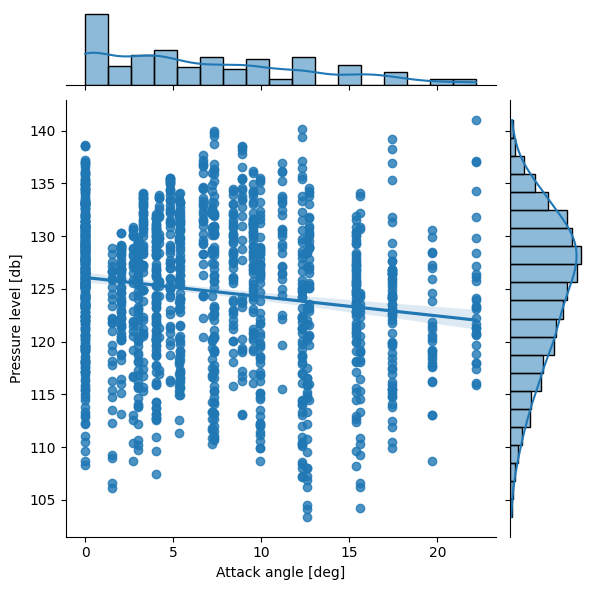

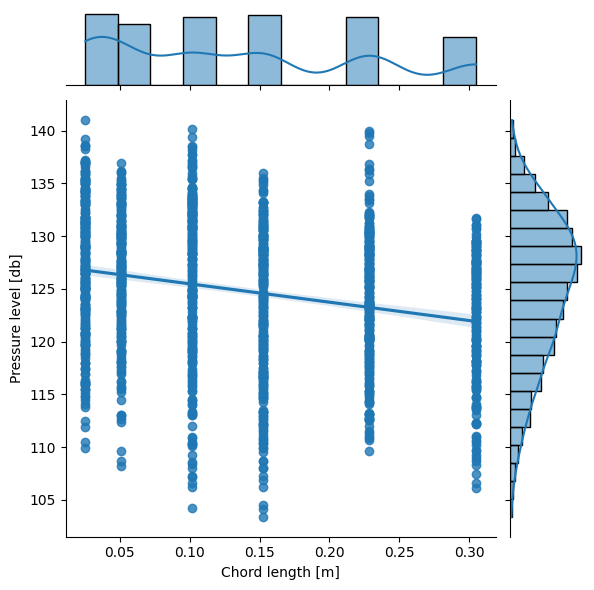

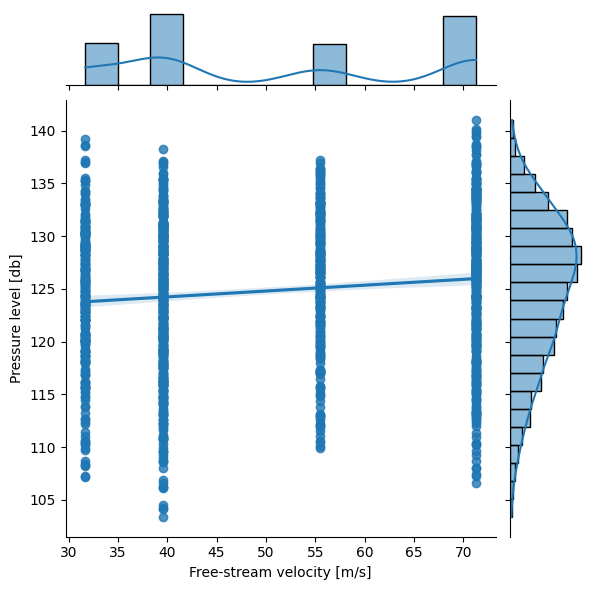

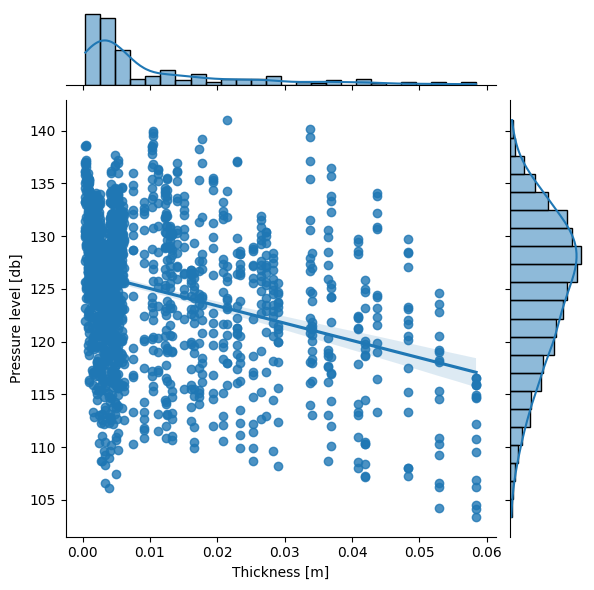

In [ ]:
for i in range(len(df.columns)-1):
    sns.jointplot(x=df.columns[i], y=df.columns[-1], data=df, kind='reg')
    plt.show()

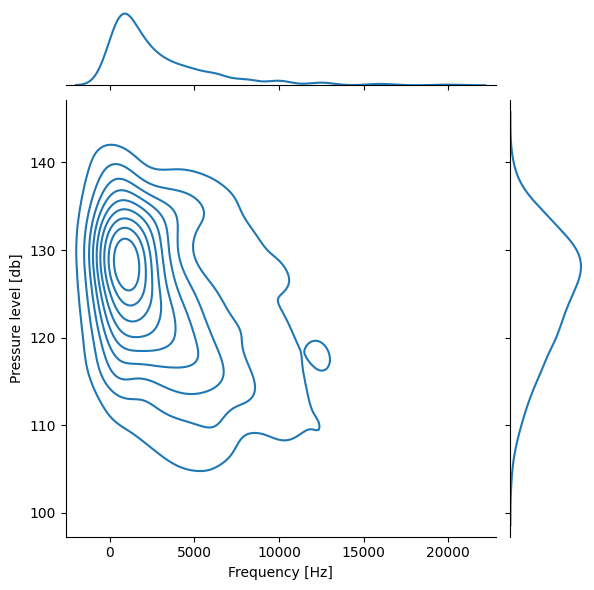

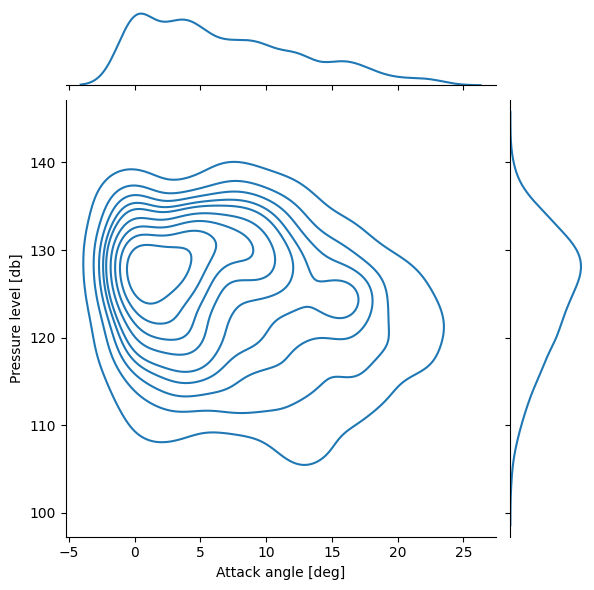

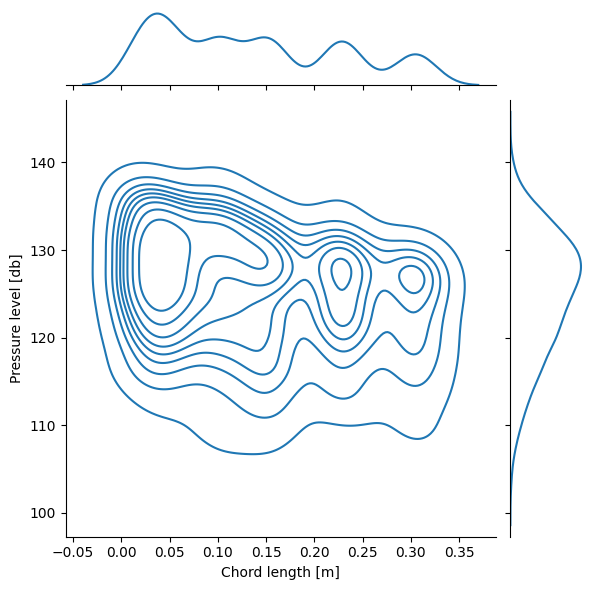

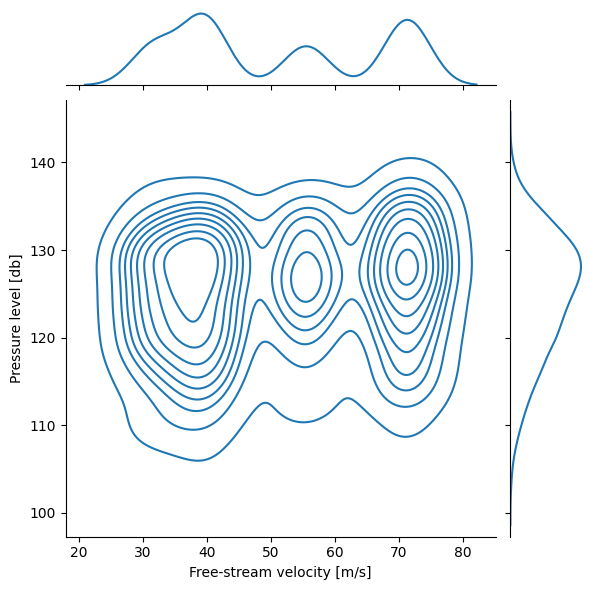

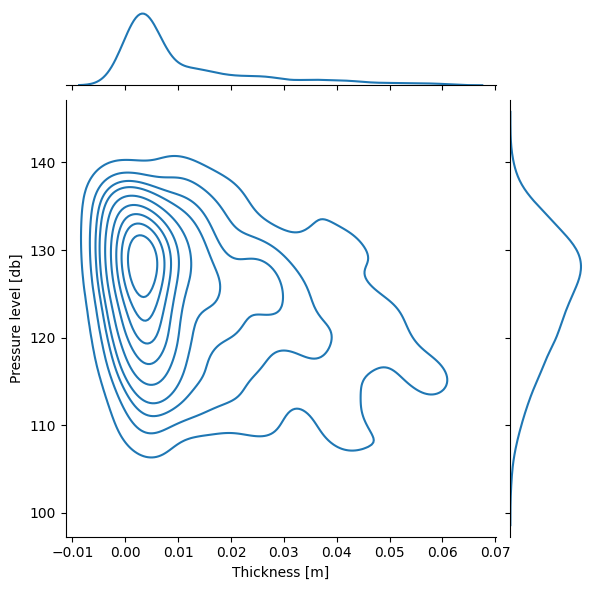

In [ ]:
for i in range(len(df.columns)-1):
    sns.jointplot(x=df.columns[i], y=df.columns[-1], data=df, kind='kde')
    plt.show()

"d:\Study\ГТДиГТУ\GTE\Расчеты\airfoil_noise/exports/pair_plot.png" file has created!
"export2" elapsed 3.6293 seconds


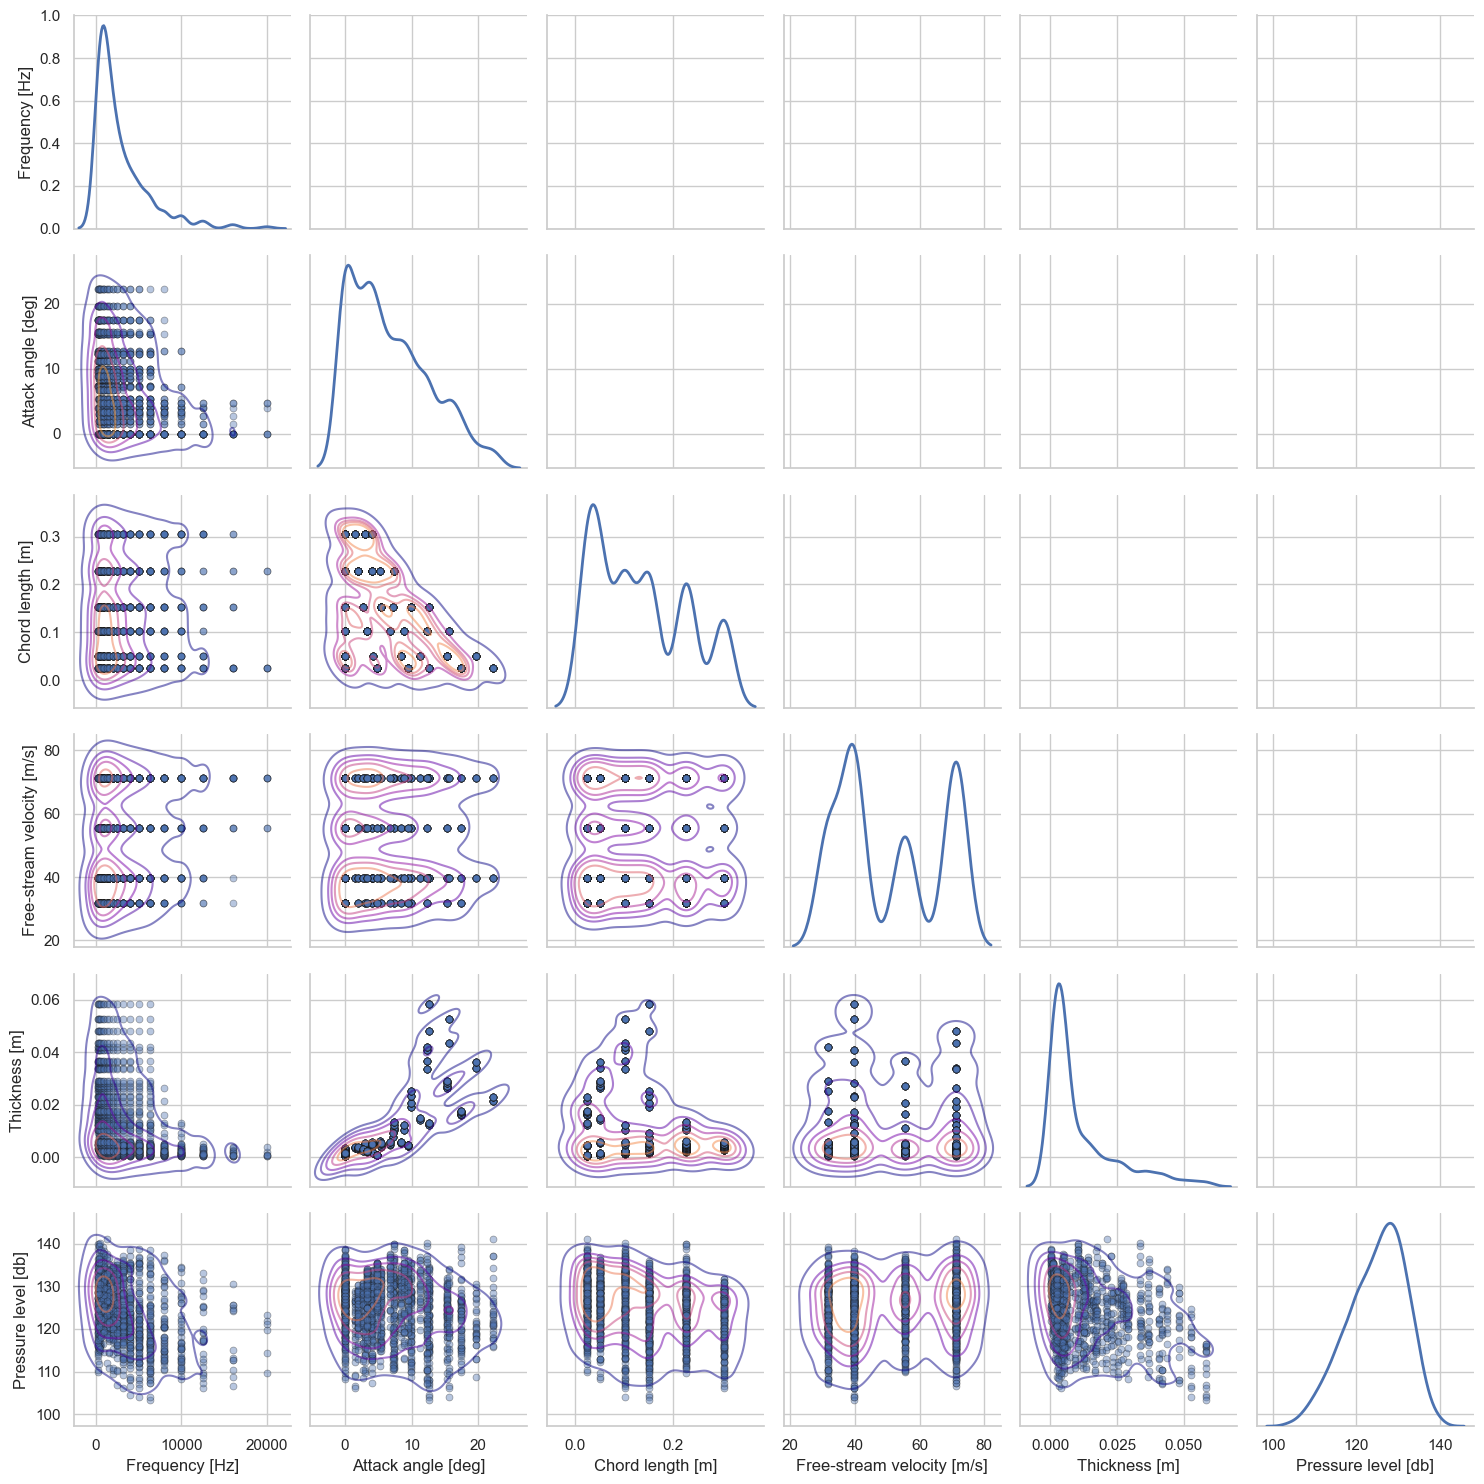

In [ ]:
pairplot(df, figsize=(15, 15), savefig=True)

# Корреляция данных

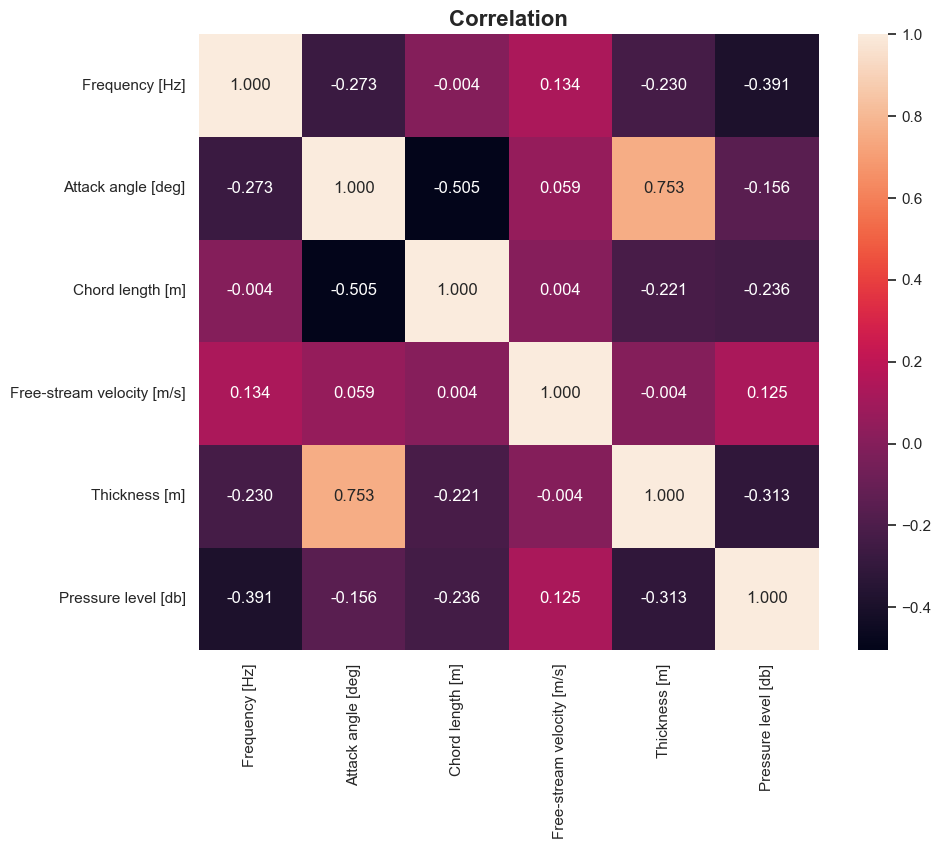

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('Correlation', fontsize=16, fontweight='bold')
sns.heatmap(df.corr(), annot=True, fmt='.3f')
plt.show();

"d:\Study\ГТДиГТУ\GTE\Расчеты\airfoil_noise/exports/correlation/correlation 24-02-08 23-13-45.png" file exporting

"d:\Study\ГТДиГТУ\GTE\Расчеты\airfoil_noise/exports/correlation/correlation 24-02-08 23-13-45.png" file has created!
"export2" elapsed 1.0576 seconds


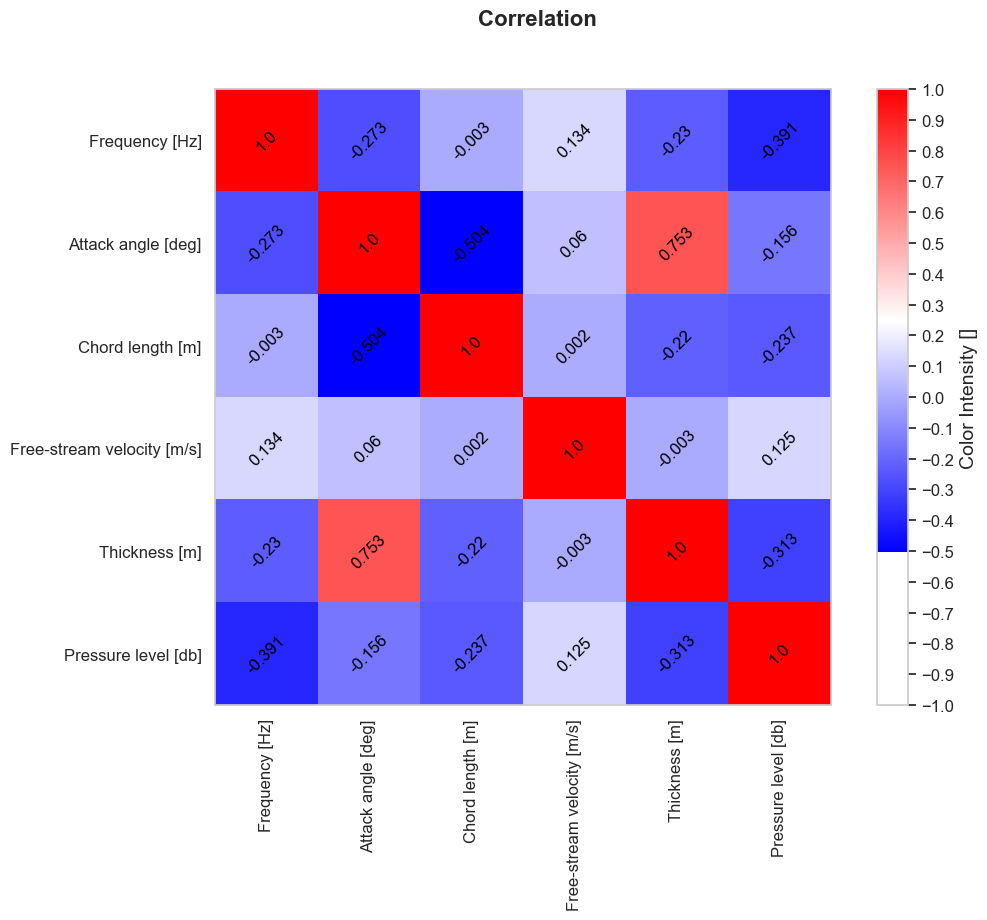

In [ ]:
show_correlation(df, rnd=3, figsize=(12, 8), savefig=True)

# Разделение данных для обучения и тестирования

In [ ]:
test_size = 0.2
random_state = 0 # семя рандома

In [ ]:
test_df = df.sample(frac=test_size, random_state=random_state)
train_df = df.drop(test_df.index)

In [ ]:
train_df.shape, test_df.shape

((1202, 6), (301, 6))

# Анализ  тренировочного датасета

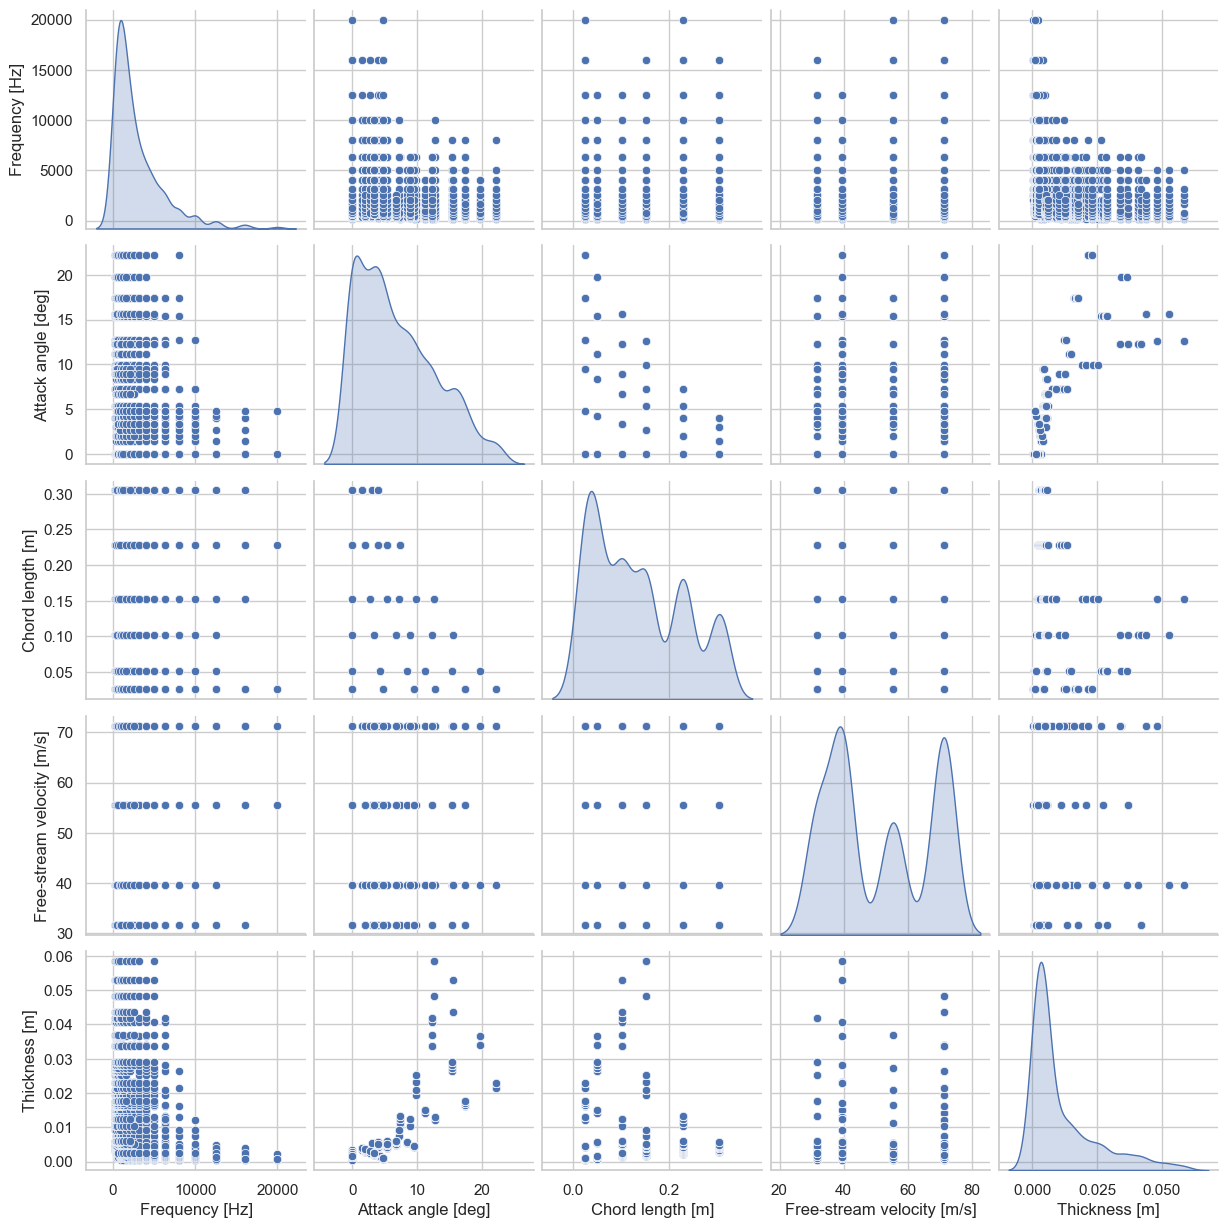

In [ ]:
sns.pairplot(train_df[df.columns[:-1]], diag_kind='kde');

In [ ]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Frequency [Hz],1202.0,2898.273710,3101.352542,200.000000,800.000000,1800.000000,4000.000000,20000.000000
Attack angle [deg],1202.0,6.882113,5.984695,0.000000,2.000000,5.400000,11.200000,22.200000
Chord length [m],1202.0,0.135072,0.093673,0.025400,0.050800,0.101600,0.228600,0.304800
Free-stream velocity [m/s],1202.0,51.191348,15.661998,31.700000,39.600000,55.500000,71.300000,71.300000
Thickness [m],1202.0,0.011248,0.013210,0.000401,0.002514,0.004968,0.016104,0.058411
Pressure level [db],1202.0,124.844381,6.908659,104.130000,120.100250,125.626000,130.085000,140.987000


# Разделение данных на признаки и целевую функцию

In [ ]:
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop('Pressure level [db]')
test_labels = test_features.pop('Pressure level [db]')

In [ ]:
pd.concat([train_features, train_labels], axis=1)

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
3,1600,0.0,0.3048,71.3,0.002663,127.591
6,3150,0.0,0.3048,71.3,0.002663,125.201
7,4000,0.0,0.3048,71.3,0.002663,123.061
8,5000,0.0,0.3048,71.3,0.002663,121.301
...,...,...,...,...,...,...
1497,2000,15.6,0.1016,39.6,0.052849,110.894
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604


# Нормализация

In [ ]:
train_df.describe().transpose()[['mean', 'std']]

,mean,std
Frequency [Hz],2898.273710,3101.352542
Attack angle [deg],6.882113,5.984695
Chord length [m],0.135072,0.093673
Free-stream velocity [m/s],51.191348,15.661998
Thickness [m],0.011248,0.013210
Pressure level [db],124.844381,6.908659


In [ ]:
normalizer = Normalization(axis=-1) 

In [ ]:
normalizer.adapt(np.array(train_features))

In [ ]:
pd.DataFrame(normalizer.mean, columns=train_features.columns, index=['mean'])

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m]
mean,2898.273682,6.882113,0.135072,51.191349,0.011248


In [ ]:
train_features

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m]
0,800,0.0,0.3048,71.3,0.002663
3,1600,0.0,0.3048,71.3,0.002663
6,3150,0.0,0.3048,71.3,0.002663
7,4000,0.0,0.3048,71.3,0.002663
8,5000,0.0,0.3048,71.3,0.002663
...,...,...,...,...,...
1497,2000,15.6,0.1016,39.6,0.052849
1498,2500,15.6,0.1016,39.6,0.052849
1499,3150,15.6,0.1016,39.6,0.052849
1500,4000,15.6,0.1016,39.6,0.052849


In [ ]:
pd.DataFrame(normalizer(train_features), columns=train_features.columns)

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m]
0,-0.676849,-1.150431,1.812664,1.284448,-0.650127
1,-0.418790,-1.150431,1.812664,1.284448,-0.650127
2,0.081200,-1.150431,1.812664,1.284448,-0.650127
3,0.355388,-1.150431,1.812664,1.284448,-0.650127
4,0.677963,-1.150431,1.812664,1.284448,-0.650127
...,...,...,...,...,...
1197,-0.289760,1.457303,-0.357478,-0.740402,3.150490
1198,-0.128473,1.457303,-0.357478,-0.740402,3.150490
1199,0.081200,1.457303,-0.357478,-0.740402,3.150490
1200,0.355388,1.457303,-0.357478,-0.740402,3.150490


# Определение последовательности обучения

In [ ]:
activation = activations.relu

In [ ]:
model = Sequential()

model.add(Input(shape=(len(df.columns)-1,)))
model.add(normalizer)
model.add(layers.Flatten())
#model.add(layers.Dense(units=64, activation=activation, input_shape=[len(train_df.keys())]))
#model.add(layers.Dense(units=64, activation=activation))
model.add(layers.Dense(units=1))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5)                 │         11 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 5)                 │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1)                 │          6 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 17 (72.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 11 (48.00 B)

# Компиляция модели

tf.optimizers.

1) SGD  # Классический оптимизатор, который обновляет веса в направлении антиградиента функции потерь
2) Adam  # Оптимизатор, сочетающий в себе преимущества адаптивного градиентного спуска (Adagrad) и Root Mean Square Propagation (RMSprop).
3) RMSprop  # Оптимизатор адаптирует скорость обучения для каждого параметра на основе истории градиентов для этого параметра.
4) Adagrad  # Оптимизатор уменьшает скорость обучения для параметров, которые редко или никогда не обновлялись, и увеличивает скорость обучения для параметров, которые часто обновлялись
5) Adadelta  # Оптимизатор является расширением Adagrad и использует только последние градиенты для обновления параметров.
6) Adamax  # Оптимизатор является вариантом Adam, который использует бесконечную норму вместо L2 нормы для обновления параметров.
6) Nadam  # Оптимизатор является комбинацией методов Nesterov Accelerated Gradient (NAG) и Adam

In [ ]:
learning_rate = 0.1
optimizer = optimizers.Adam(learning_rate=learning_rate)
loss = 'mae'
metrics =  ['mae', 'mse']

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

# Обучение модели

In [ ]:
epochs = 100
batch_size = 32
verbose = False  # динамическое прогресс

monitor = 'loss' # что мониторить
min_delta = 0.01 # сравнивать с каким значением
patience = 5 # в течении скольких эпох

callbacks = [keras.callbacks.EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose),
             keras.callbacks.ModelCheckpoint(monitor=monitor, filepath='checkpoints/model_{epoch:d}.keras', save_best_only=True, verbose=verbose)]

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    epochs=epochs,
    validation_data=(test_features, test_labels),
    #validation_split = 0.2,  # данные ранее не были разделены на тренировочные и тестовые
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=verbose)

CPU times: total: 5.98 s
Wall time: 5.06 s


# Анализ обучения

In [ ]:
max(history.epoch)

42

"d:\Study\ГТДиГТУ\GTE\Расчеты\airfoil_noise/exports/training_plot.png" file exporting

"d:\Study\ГТДиГТУ\GTE\Расчеты\airfoil_noise/exports/training_plot.png" file has created!
"export2" elapsed 0.9583 seconds


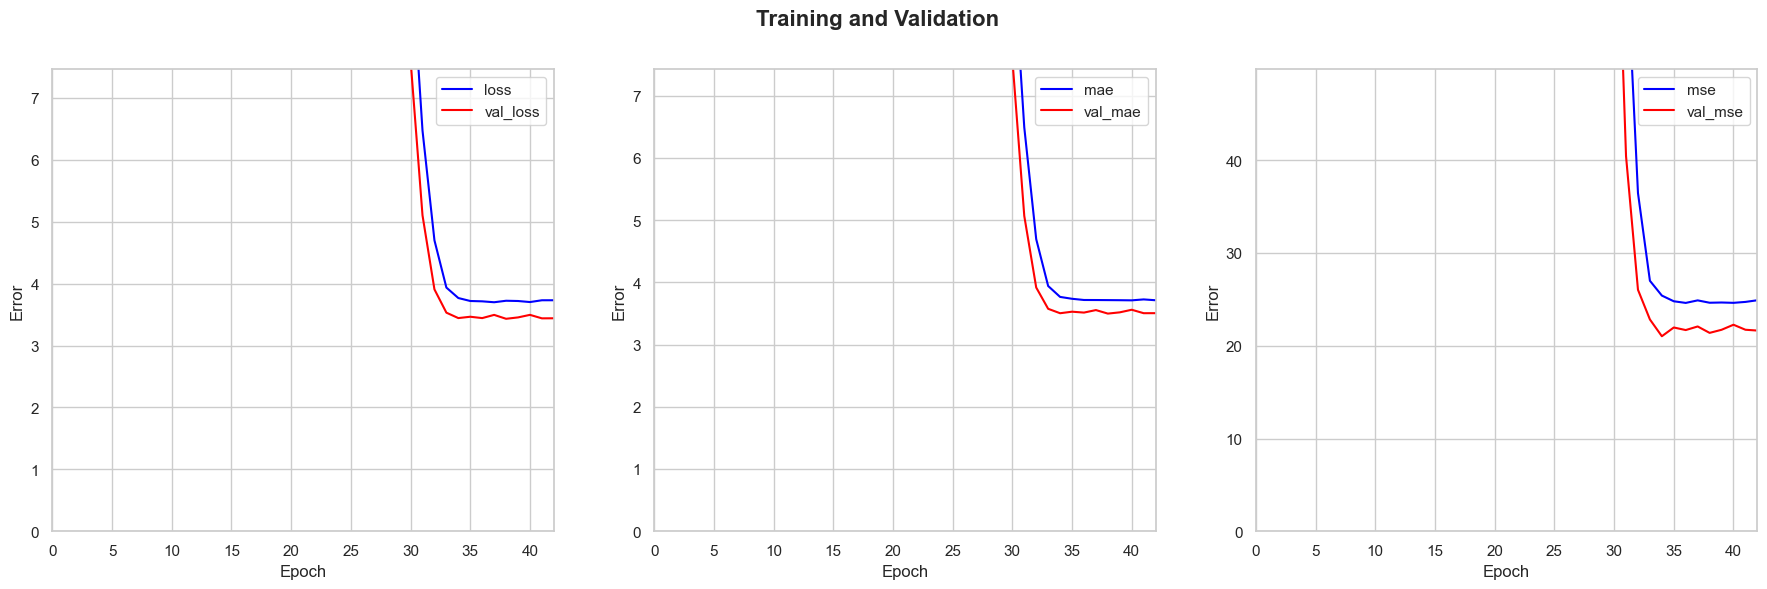

In [ ]:
training_plot(history, figsize=(22, 6), savefig=True)

In [ ]:
hist = pd.DataFrame(history.history)
hist.index.rename('epoch', inplace=True)
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
epoch,,,,,,
38,3.724122,3.716233,24.643953,3.432694,3.499430,21.393463
39,3.720031,3.714724,24.669590,3.454980,3.519584,21.727530
40,3.703148,3.712562,24.634153,3.496173,3.561225,22.271999
41,3.731941,3.727410,24.733175,3.439893,3.505842,21.730974
42,3.732241,3.714008,24.912491,3.441040,3.506347,21.643938


Оценка производительности модели

In [ ]:
test_results = dict()
test_results['model'] = model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
test_results

{'model': [3.4410400390625, 3.5063469409942627, 21.643938064575195]}

In [ ]:
test_predictions = model.predict(test_features.to_numpy()).flatten()

 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


"d:\Study\ГТДиГТУ\GTE\Расчеты\airfoil_noise/exports/predictions_plot.png" file exporting

"d:\Study\ГТДиГТУ\GTE\Расчеты\airfoil_noise/exports/predictions_plot.png" file has created!
"export2" elapsed 0.5588 seconds


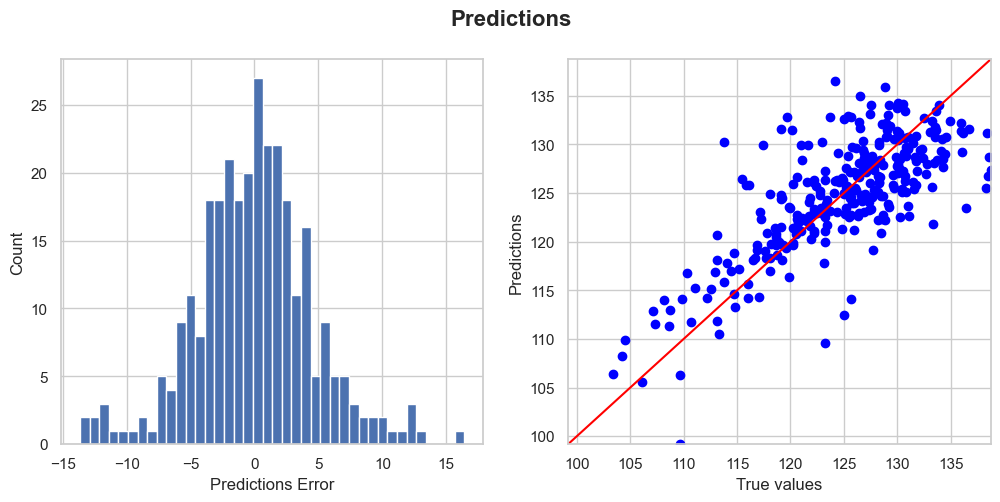

In [ ]:
predictions_plot(test_labels, test_predictions, figsize=(12, 5), savefig=True)

# Экспорт модели

In [ ]:
model_name = 'model_airfoil_noise'
model_name += '.keras'

In [ ]:
if model_name not in os.listdir(): 
    model.save(model_name)
    print('model has saved')
else:
    print('model has not saved!')

model has not saved!


In [ ]:
os.path.exists(model_name)

True

# Импорт модели

In [ ]:
os.listdir()

['airfoil_self_noise.dat',
 'app.py',
 'model.pkl',
 'home.html',
 'Airfoil Self-Noise - UCI Machine Learning Repository.html',
 'airfoil_noise_by_sklearn.ipynb',
 'airfoil_noise_by_tf.ipynb',
 'exports',
 'checkpoints',
 'model_airfoil_noise.keras',
 'airfoil_noise_by_tf.html']

In [ ]:
model.save(model_name)

In [ ]:
model = keras.models.load_model('model_airfoil_noise.keras')

# Тестирование

## Автоматическое тестирование

In [ ]:
pred_df = pd.concat([df.iloc[:, -1:],
           pd.DataFrame(model.predict(df.iloc[:, :-1]), columns=['Predicted Pressure level [db]'])], 
           axis=1)
pred_df

 1/47 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Pressure level [db],Predicted Pressure level [db]
0,126.201,127.861328
1,125.201,127.550491
2,125.951,127.161934
3,127.591,126.617966
4,127.461,125.996277
...,...,...
1498,110.264,114.127243
1499,109.254,113.117004
1500,106.604,111.795929
1501,106.224,110.241722


## Ручное тестирование

In [ ]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [ ]:
airfoil_props = {"Frequency [Hz]": [800, 6300], 
                 "Attack angle [deg]": [0, 15.6], 
                 "Chord length [m]" : [0.3048, 0.1016], 
                 "Free-stream velocity [m/s]": [71.3, 39.6], 
                 "Thickness [m]": [0.002663, 0.052849]}
airfoil_props = pd.DataFrame(airfoil_props)
airfoil_props

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m]
0,800,0.0,0.3048,71.3,0.002663
1,6300,15.6,0.1016,39.6,0.052849


In [ ]:
%%time
for predict in model.predict(airfoil_props.to_numpy()):
    print(f'Pressure level [db]: {predict[0]} ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Pressure level [db]: 127.86139678955078 
Pressure level [db]: 108.22119140625 
CPU times: total: 78.1 ms
Wall time: 63.8 ms


In [ ]:
pd.concat([airfoil_props, pd.DataFrame(model.predict(airfoil_props.to_numpy()), columns=['Pressure level [db]'])], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,127.861397
1,6300,15.6,0.1016,39.6,0.052849,108.221191
